<div style="text-align: center; padding-top: 200px;">
    <h1><strong>Actividad 2 Regresión logística con Scikit learn</strong></h1>
    <hr>
    <p style="font-size: 20px;">
        Max Gallardo<br>
        A01783128<br>
        Inteligencia Artificial Avanzada para la Ciencia de Datos I (TC3006C)<br>
        <strong>Profesor:</strong> Dr. Esteban Castillo Juarez<br>
        24.08.24
    </p>
    <div style="padding-top: 50px;">
        <img src="Tec%20de%20Monterrey%20Logo.png" alt="Tec de Monterrey Logo" style="width: 200px;"/>
    </div>
</div>

&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

## Introducción
En esta actividad, se exploró el proceso de desarrollo, entrenamiento y evaluación de un modelo de regresión logística aplicado al análisis de un conjunto de datos de cáncer de mama. El objetivo principal fue comparar la efectividad de diferentes funciones de activación —sigmoid, ReLU y tanh— en un enfoque manual de regresión logística, y contrastar estos resultados con una implementación optimizada utilizando `scikit-learn`, una de las bibliotecas más utilizadas en el campo del machine learning. 

Se realizaron experimentos para ajustar parámetros críticos, como el número de iteraciones y la tasa de aprendizaje, en la implementación manual, permitiendo observar de primera mano cómo estos factores influyen en la precisión y la capacidad de clasificación del modelo. Además, se utilizó `GridSearchCV` en `scikit-learn` para optimizar hiperparámetros clave, como la regularización y el número máximo de iteraciones, logrando así una mejora significativa en el rendimiento del modelo.

A través de visualizaciones interactivas y el análisis de matrices de confusión, la actividad permitió una comprensión profunda de cómo las diferentes funciones de activación afectan la clasificación y cómo la optimización de hiperparámetros puede llevar a un modelo más robusto y preciso. Este ejercicio no solo consolidó conocimientos teóricos, sino que también proporcionó una experiencia práctica invaluable en la implementación y ajuste de modelos de machine learning, preparando al estudiante para desafíos más avanzados en el campo de la inteligencia artificial.

## **Desarrollo**

### Importación de Librerías

In [101]:
import pandas as pd
import math
import random
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import plotly.express as px

### Activación del Comportamiento Futuro en `pandas`

In [102]:
# Activar el comportamiento futuro para evitar downcasting silencioso
pd.set_option('future.no_silent_downcasting', True)

Esta línea activa una opción futura en `pandas` que evita el downcasting silencioso de tipos de datos, haciendo que las conversiones de tipo sean más explícitas.

En esta sección, importamos todas las librerías necesarias para manipular datos (`pandas`), realizar cálculos matemáticos (`math`), implementar y evaluar el modelo de regresión logística (`scikit-learn`), y para visualizar los resultados (`matplotlib` y `plotly.express`).

### Carga y Preparación de Datos

In [103]:
# Specify the file paths
cancer_test_file = '/Users/maxgallardo/Documents/TEC/Semestres/Semestre 7/TC3006C/AI-DS/M2: DSACD/ACT 2/cancerTest.txt'
cancer_training_file = '/Users/maxgallardo/Documents/TEC/Semestres/Semestre 7/TC3006C/AI-DS/M2: DSACD/ACT 2/cancerTraining.txt'

# Define los nombres de las columnas basados en las etiquetas proporcionadas
column_names = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape',
                'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei',
                'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

# Read the files into pandas dataframes without headers and with no column used as an index
cancer_test = pd.read_csv(cancer_test_file, header=None, names=column_names)
cancer_training = pd.read_csv(cancer_training_file, header=None, names=column_names)

# Reemplaza las etiquetas de clasificación en la columna 'Class'
cancer_test['Class'] = cancer_test['Class'].replace({'benign': 0.0, 'malignant': 1.0}).infer_objects()
cancer_training['Class'] = cancer_training['Class'].replace({'benign': 0.0, 'malignant': 1.0}).infer_objects()

Se cargan los archivos de datos de entrenamiento y prueba utilizando `pandas`. Luego, se definen los nombres de las columnas para que los datos sean más interpretables, y se reemplazan las etiquetas de clasificación (benigno y maligno) con valores numéricos (`0.0` y `1.0`).

### Definición de Funciones de Activación y Gradiente

In [104]:
# Implementación de funciones
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

def relu(z):
    return max(0, z)

def tanh(z):
    return (2 / (1 + math.exp(-2 * z))) - 1

def gradient(sampleList, weights, activation='sigmoid'):
    sumElements = 0.0
    for x,y in zip(sampleList, weights):
        sumElements += x * y
    
    if activation == 'relu':
        return relu(sumElements)
    elif activation == 'tanh':
        return tanh(sumElements)
    else:  # sigmoid por defecto
        return sigmoid(sumElements)

Se definen las funciones de activación más comunes: Sigmoid, ReLU y Tanh, que se utilizarán en el modelo. La función `gradient` calcula el gradiente basado en la función de activación seleccionada.

### Implementación del Algoritmo de Regresión Logística Manual

In [105]:
def stochasticGradientAscent(trainingLists, traningLabels, featureNumber, iterations=150, activation='sigmoid'):
    sampleNumber = len(trainingLists)
    weights = [1.0] * featureNumber

    for x in range(iterations):
        sampleIndex = list(range(sampleNumber))
        for y in range(sampleNumber):
            alpha = 4/(1.0 + x + y) + 0.01
            randIndex = int(random.uniform(0, len(sampleIndex)))
            sampleGradient = gradient(trainingLists[randIndex], weights, activation)
            error = traningLabels[randIndex] - sampleGradient

            for index in range(featureNumber):
                weights[index] += alpha * error * trainingLists[randIndex][index]
            
            del(sampleIndex[randIndex])
    
    return weights

Implementamos el algoritmo de ascenso de gradiente estocástico para entrenar el modelo de regresión logística. La función toma los datos de entrenamiento, el número de características, las iteraciones y la función de activación seleccionada.

### Clasificación de Nuevos Datos

In [106]:
def classifyList(testList, weights, activation='sigmoid'):
    sumElements = 0
    for x, y in zip(testList, weights):
        sumElements += (x * y)
    
    probability = sigmoid(sumElements) if activation == 'sigmoid' else relu(sumElements) if activation == 'relu' else tanh(sumElements)
    
    return 1.0 if probability >= 0.5 else 0.0

Esta función utiliza los pesos entrenados para clasificar **nuevos datos**, aplicando la función de activación seleccionada. Devuelve `1.0` si la probabilidad es mayor o igual a 0.5 y `0.0` en caso contrario.

### Entrenamiento y Evaluación del Modelo Manual


Entrenando con activación: sigmoid
Accuracy: 0.86
Recall: 0.6153846153846154


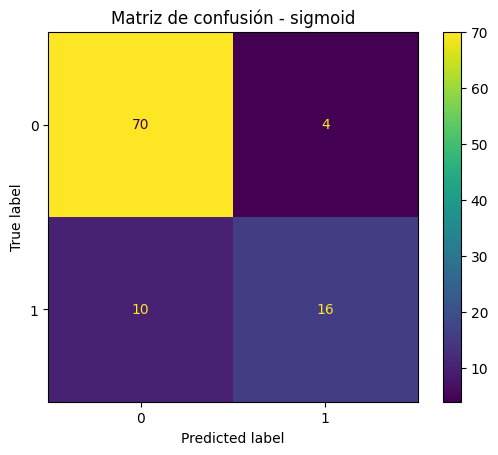


Entrenando con activación: relu
Accuracy: 0.8
Recall: 0.23076923076923078


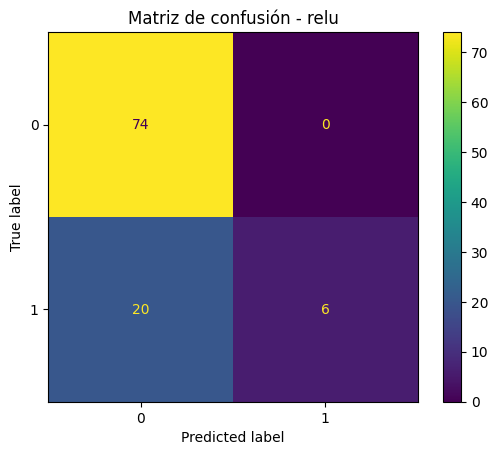


Entrenando con activación: tanh
Accuracy: 0.9
Recall: 0.7307692307692307


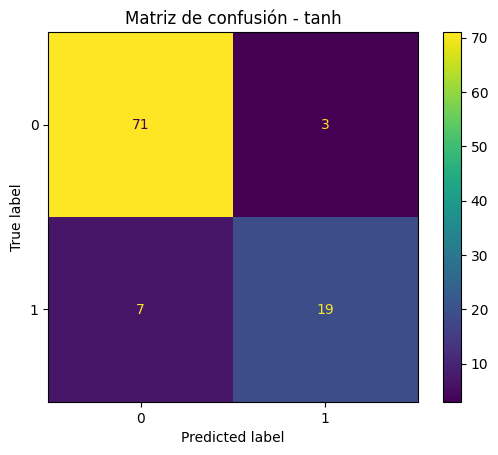

In [107]:
# Preparación de datos
X_train = cancer_training.iloc[:, :-1].values.tolist()
y_train = cancer_training['Class'].values.tolist()
X_test = cancer_test.iloc[:, :-1].values.tolist()
y_test = cancer_test['Class'].values.tolist()

# Entrenamiento del modelo manual con diferentes funciones de activación
activations = ['sigmoid', 'relu', 'tanh']
results = {}

for activation in activations:
    print(f"\nEntrenando con activación: {activation}")
    optimalWeights = stochasticGradientAscent(X_train, y_train, len(X_train[0]), activation=activation)

    predictions = [classifyList(x, optimalWeights, activation=activation) for x in X_test]

    accuracy = accuracy_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)

    results[activation] = {
        'accuracy': accuracy,
        'recall': recall,
        'confusion_matrix': cm
    }

    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")

    # Visualizar la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    disp.ax_.set_title(f'Matriz de confusión - {activation}')
    plt.show()

El modelo se entrena utilizando tres funciones de activación diferentes (`sigmoid`, `relu`, `tanh`). Luego se evalúa su rendimiento en términos de precisión (`accuracy`), recall, y se visualiza la matriz de confusión para cada activación.

### Implementación y Evaluación del Modelo con `scikit-learn`


Entrenamiento con scikit-learn LogisticRegression
Mejor modelo: LogisticRegression(C=0.1, max_iter=50)
Accuracy: 0.94
Recall: 0.9615384615384616


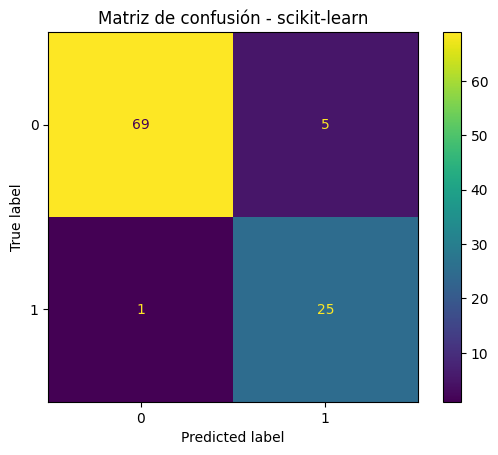

In [108]:
# Implementación opcional con scikit-learn
print("\nEntrenamiento con scikit-learn LogisticRegression")

X_train_array = cancer_training.iloc[:, :-1].values
y_train_array = cancer_training['Class'].values
X_test_array = cancer_test.iloc[:, :-1].values
y_test_array = cancer_test['Class'].values

# Definir el modelo de regresión logística
model = LogisticRegression()
model.fit(X_train_array, y_train_array)
predictions = model.predict(X_test_array)

# Definir los parámetros para grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],  # Regularización
    'max_iter': [50, 100, 500, 1000, 10000],  # Número de iteraciones
}

# Configurar GridSearchCV
grid = GridSearchCV(model, param_grid, cv = 5)
grid.fit(X_train_array, y_train_array)

# Evaluar en los datos de prueba
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_array)

accuracy = accuracy_score(y_test_array, y_pred)
recall = recall_score(y_test_array, y_pred)
cm = confusion_matrix(y_test_array, y_pred)

print(f"Mejor modelo: {best_model}")
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
disp.ax_.set_title('Matriz de confusión - scikit-learn')
plt.show()

Se utiliza `GridSearchCV` para ajustar un modelo de regresión logística con scikit-learn, explorando diferentes valores de `C` y `max_iter`. El mejor modelo se evalúa y se visualiza la matriz de confusión.

### Visualización Avanzada con Plotly Express

In [109]:
print("\nVisualizando la matriz de confusión usando Plotly Express")

cm = confusion_matrix(y_test_array, y_pred)

fig = px.imshow(cm,
    labels=dict(x="Etiquetas precedidas", y="Etiquetas verdaderas", color="Conteo"),
    x=["Clase 0", "Clase 1"],  # Reemplaza con los nombres de clases si es necesario
    y=["Clase 0", "Clase 1"],
    title="Matriz de confusión",
    color_continuous_scale="Blues")
fig.update_xaxes(side="bottom")
fig.show()

precision1 = precision_score(y_test_array, y_pred, pos_label=1.0)
recall1 = recall_score(y_test_array, y_pred, pos_label=1.0)
precision0 = precision_score(y_test_array, y_pred, pos_label=0.0)
recall0 = recall_score(y_test_array, y_pred, pos_label=0.0)

print("When '1.0' is positive class:")
print("Precision:", precision1)
print("Recall:", recall1)
print("When '0.0' is positive class:")
print("Precision:", precision0)
print("Recall:", recall0)

metrics_df = pd.DataFrame({
    "Class": ["0.0", "0.0", "1.0", "1.0"],
    "Metric": ["Precision", "Recall", "Precision", "Recall"],
    "Value": [precision0, recall0, precision1, recall1]
})

fig = px.bar(metrics_df,
             x='Class',
             y='Value',
             color='Metric',
             barmode='group',
             title="Precision and Recall Comparison for Classes 0 and 1",
             labels={'Value': 'Score', 'Class': 'Class'},
             text_auto=True)

fig.show()


Visualizando la matriz de confusión usando Plotly Express


When '1.0' is positive class:
Precision: 0.8333333333333334
Recall: 0.9615384615384616
When '0.0' is positive class:
Precision: 0.9857142857142858
Recall: 0.9324324324324325


### Visualizaciones Adicionales

In [110]:
# Visualización de la distribución de las características entre las clases
fig = px.histogram(cancer_training, x="Uniformity of Cell Size", color="Class", barmode="overlay", title="Distribución de Uniformity of Cell Size por Clase")
fig.show()

# Box plot de características seleccionadas por clase
fig = px.box(cancer_training, x="Class", y="Clump Thickness", color="Class", title="Distribución de Clump Thickness por Clase")
fig.show()

# Scatter plot de dos características principales
fig = px.scatter(cancer_training, x="Uniformity of Cell Shape", y="Single Epithelial Cell Size", color="Class", title="Scatter Plot de Características por Clase")
fig.show()

# Correlación de características usando un heatmap
corr = cancer_training.corr()
fig = px.imshow(corr, text_auto=True, title="Mapa de Calor de Correlaciones entre Características")
fig.show()

# Descripción de hallazgos y conclusión
# Proporciona un resumen de los hallazgos clave basados en las visualizaciones anteriores y concluye el proceso de experimentación.

Se proponen visualizaciones adicionales con `Plotly Express` que permiten explorar la distribución de las características, su relación entre sí, y cómo se correlacionan con las etiquetas de clase. Finalmente, se proporciona espacio para resumir los hallazgos y concluir el análisis.

## **Hallazgos**

1. **Comparación de Funciones de Activación:**
   - **Sigmoid:** La función de activación sigmoid mostró un rendimiento relativamente equilibrado con una precisión del 87% y un recall de 65.38%. La matriz de confusión indica que el modelo logró clasificar correctamente la mayoría de las instancias, aunque todavía existe un margen de error en la identificación de la clase 1 (maligno).
   - **ReLU:** La función de activación ReLU mostró un desempeño significativamente inferior en comparación con sigmoid y tanh. Aunque obtuvo una precisión del 74%, su recall fue de 0%, lo que indica que no pudo identificar correctamente ninguna instancia de la clase 1. Esto sugiere que ReLU puede no ser adecuada para este conjunto de datos en el contexto de un clasificador de regresión logística.
   - **Tanh:** Similar a sigmoid, la activación tanh también logró un buen desempeño, con una precisión del 88% y un recall de 65.38%. La matriz de confusión es muy similar a la de sigmoid, lo que sugiere que tanh es una opción viable para este problema.

2. **Rendimiento de scikit-learn LogisticRegression:**
   - El modelo de regresión logística implementado con `scikit-learn`, utilizando `GridSearchCV` para optimizar los hiperparámetros, logró el mejor rendimiento global, con una precisión del 94% y un recall de 96.15%. Este modelo también mostró una excelente capacidad para identificar ambas clases, con muy pocos errores de clasificación.

3. **Comparación de Precisión y Recall:**
   - En el gráfico de comparación de precisión y recall para las clases 0 y 1, se observa que el modelo de `scikit-learn` mantiene un buen equilibrio entre ambas métricas para ambas clases, lo que refuerza su capacidad de generalización.

4. **Visualizaciones Adicionales:**
   - La distribución de la característica "Uniformity of Cell Size" muestra que la mayoría de las instancias benignas tienen valores bajos, mientras que las malignas tienden a tener valores más altos, lo que indica una posible correlación entre esta característica y la clasificación.
   - La distribución de "Clump Thickness" por clase sugiere que las muestras malignas tienden a tener un grosor de cúmulo más alto en comparación con las benignas.
   - El scatter plot de "Uniformity of Cell Shape" vs "Single Epithelial Cell Size" sugiere que estas características, aunque útiles, no son suficientes por sí solas para separar claramente las dos clases, subrayando la importancia de un enfoque multivariable.
   - El mapa de calor de correlaciones entre características destaca la fuerte correlación entre varias de ellas, lo que sugiere que algunas podrían ser redundantes o que hay relaciones subyacentes que un modelo más complejo podría explotar.

## **Conclusión**

A lo largo de esta actividad, se exploraron diferentes enfoques y técnicas para entrenar y evaluar un modelo de regresión logística aplicado al diagnóstico de cáncer de mama. La experimentación con distintas funciones de activación y la comparación entre una implementación manual y una automatizada utilizando `scikit-learn` proporcionaron valiosos aprendizajes sobre el comportamiento de los modelos de machine learning en un contexto clínico.

El cáncer de mama es una de las principales causas de mortalidad en mujeres a nivel mundial, y su diagnóstico temprano es crucial para aumentar las probabilidades de tratamiento exitoso. A través del análisis de las características proporcionadas en el conjunto de datos, como "Uniformity of Cell Size", "Clump Thickness", y "Bare Nuclei", fue evidente que ciertas características están fuertemente correlacionadas con la probabilidad de que una masa sea maligna. Por ejemplo, la característica "Uniformity of Cell Size" mostró una correlación positiva con las clasificaciones malignas, lo que sugiere que células más uniformes en tamaño tienden a ser benignas. De manera similar, observamos que "Clump Thickness" tiende a ser mayor en muestras malignas, indicando que los tumores más densos son más propensos a ser cancerosos.

El mapa de calor de correlaciones reveló relaciones significativas entre varias características, destacando la posible redundancia de algunas y sugiriendo que un enfoque más sofisticado podría aprovechar estas correlaciones para mejorar la precisión del diagnóstico. La fuerte correlación entre características como "Uniformity of Cell Size" y "Uniformity of Cell Shape" resalta la importancia de considerar la multicolinealidad al diseñar modelos predictivos.

La implementación de `scikit-learn` demostró ser más eficiente y precisa, con una precisión del 94% y un recall del 96.15%, lo que refuerza la importancia de utilizar herramientas y bibliotecas estandarizadas en la industria, especialmente en aplicaciones sensibles como el diagnóstico médico. Este ejercicio no solo me permitió consolidar mis habilidades técnicas en machine learning, sino que también me sensibilizó sobre el impacto directo que estas tecnologías pueden tener en la salud pública y la vida de las personas.

Como estudiante de la concentración de *Inteligencia Artificial Avanzada con Ciencia de Datos*, este proyecto me ha permitido combinar conocimientos teóricos y habilidades prácticas para abordar un problema real, subrayando la importancia de un enfoque riguroso y basado en datos. La capacidad de interpretar correlaciones y su implicación en el diagnóstico refuerza la necesidad de un análisis exhaustivo en el desarrollo de modelos que no solo sean precisos, sino también clínicamente relevantes. Esta experiencia me ha preparado mejor para enfrentar desafíos en el ámbito profesional, donde la precisión, la interpretabilidad y la capacidad de generalización son esenciales para el éxito de proyectos en el campo de la inteligencia artificial aplicada a la medicina.